In [104]:
import matplotlib.font_manager as font_manager
import matplotlib.dates as matdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
fontpath = expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    "text.usetex": True,            # use LaTeX to write all text
    "pgf.rcfonts": False,           # Ignore Matplotlibrc
}
mpl.rcParams.update(params)

In [2]:
from helpers import colors
import networkx as nx
import pandas as pd
import numpy as np
import json
import glob

In [3]:


cats = ["Alt-right", "Alt-lite", "Intellectual Dark Web"]

df_sources = pd.read_csv("../data/sources_final.csv")
df_sources = df_sources.set_index("Id")

channels = {}
with open("../data/rc/rec_base.jsonl") as f:
    for line in f.readlines():
        tmp = json.loads(line)
        channels[tmp["channel_id"]] = tmp

G = nx.DiGraph()

for _, edge in channels.items():
    
    if edge["channel_id"] not in df_sources.index or \
       df_sources.loc[edge["channel_id"], "Category"] not in cats:
        continue
    
    G.add_node(edge["channel_id"], name=edge["name"],
               videoCount=int(edge["statistics"]["videoCount"]),
               viewCount=int(edge["statistics"]["viewCount"]),
               subscriberCount=int(edge["statistics"]["subscriberCount"]),
               category=df_sources.loc[edge["channel_id"], "Category"]
               )

for v in glob.glob("../data/rc/*.jsonl"):
    with open(v) as f:
        for line in f.readlines():
            tmp = json.loads(line)
            channels[tmp["channel_id"]]["edges"] += tmp['edges']
            
for _, edge in channels.items():
    
    if edge["channel_id"] not in df_sources.index or \
       df_sources.loc[edge["channel_id"], "Category"] not in cats:
        continue
    
    relevant_edges = [actual_edge["channel_id"] for actual_edge in edge["edges"]
                          if actual_edge["type"].lower() in ["related channels", "canais relacionados"]
                          and  G.has_node(actual_edge["channel_id"])]
    relevant_edges = [{"channel_id": x, 
            "count": relevant_edges.count(x),
            "pct": relevant_edges.count(x)/len(relevant_edges)
            } for x in set(relevant_edges)]

    for actual_edge in relevant_edges:
        if G.has_node(actual_edge["channel_id"]):
            G.add_edge(edge["channel_id"], actual_edge["channel_id"],
                       count=actual_edge["count"],
                       pct=actual_edge["pct"])

nx.write_graphml(G, "./recommended.graphml")

In [7]:
lambdas = [
           lambda x: True, 
           lambda x:  df_sources.loc[x, "Category"] == "Alt-right",
           lambda x:  df_sources.loc[x, "Category"] == "Alt-lite",
           lambda x:  df_sources.loc[x, "Category"] == "Intellectual Dark Web",
          ]

titles = ["Wherever",
         "Alt-right",
         "Alt-lite",
         "I.D.W."]

df_list = []

for l, t in zip(lambdas, titles):

    node_list = [k for k, _ in  G.nodes.data() if l(k)]
    subs = np.array([G.nodes[n]["subscriberCount"] for n in node_list])
    subs = subs/np.sum(subs)
    cats_nodes = np.array([G.nodes[n]["category"] for n in node_list])

    candidates = node_list
    
    print(t)
    print(len(node_list))
    print(len(subs))

    weight = subs


    for it in range(100000):
        for k in range(16):
            n = np.random.choice(candidates, p = weight)
            tmp = [(j, G[i][j]["pct"]) for i,j in list(G.out_edges(n))]
            if len(tmp) == 0:
                break
            candidates, weight = list(zip(*tmp))
            df_list.append({"channel_id": n, 
                            "category": df_sources.loc[n, "Category"],
                            "step": k,
                            "Starting": t})
    print(len(df_list))

df = pd.DataFrame(df_list)
df["isar"] = (df.category == "Alt-right").astype(float)
df["isidw"] = (df.category == "Intellectual Dark Web").astype(float)
df["isal"] = (df.category == "Alt-lite").astype(float)


Wherever
293
293
221066
Alt-right
88
88
446092
Alt-lite
109
109
673724
I.D.W.
96
96
896757


In [125]:
import itertools
helper_edges_count = {}
for c1, c2 in itertools.product(cats, repeat=2):
    total_src = sum([G[u][v]["pct"] for u, v in G.edges if df_sources.loc[u, "Category"] == c1])
    val = sum([G[u][v]["pct"] for u, v in G.edges if df_sources.loc[u, "Category"] == c1 and 
                                                     df_sources.loc[v, "Category"] == c2])
    helper_edges_count[(c1,c2)] = str(round(val/total_src*100,2))+ "\%"
    
    c1 =c1.replace("Intellectual Dark Web", "I.D.W.")
    c2 =c2.replace("Intellectual Dark Web", "I.D.W.")
    
    print("{:>5}%     {:<10} to     {}".format(round(val/total_src*100,2), c1, c2))

32.94%     Alt-right  to     Alt-right
39.32%     Alt-right  to     Alt-lite
27.74%     Alt-right  to     I.D.W.
 2.57%     Alt-lite   to     Alt-right
52.23%     Alt-lite   to     Alt-lite
45.19%     Alt-lite   to     I.D.W.
 0.35%     I.D.W.     to     Alt-right
21.72%     I.D.W.     to     Alt-lite
77.93%     I.D.W.     to     I.D.W.


/home/manoelribeiro/anaconda3/envs/community_fingerprinting/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


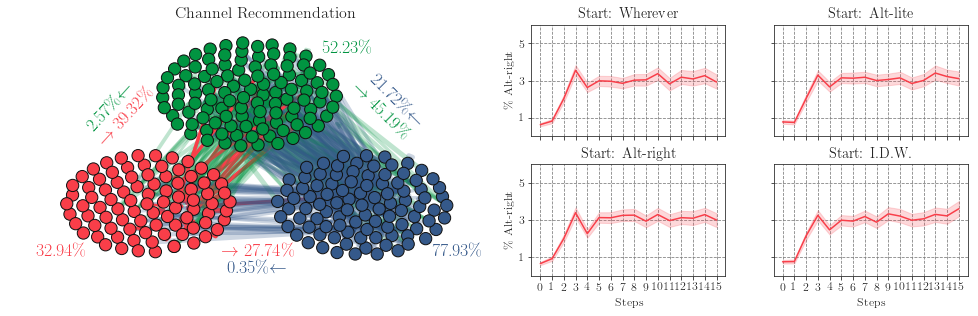

In [140]:

fig = plt.figure(constrained_layout=False, figsize=(16.5,4.5))
gs = fig.add_gridspec(nrows=2, ncols=4, wspace=0.25, hspace=0.25, top=0.9)

ax_graph = fig.add_subplot(gs[0:2, 0:2])

df_helper_pos = pd.read_csv("../data/helper_channels.csv")
pos = {k: np.array([i["x"], i["y"]]) for k, i in df_helper_pos[["x", "y"]].iterrows()}

edges = G.edges()
weights = [np.power(G[u][v]['pct'],0.25)*5 for u,v in edges]
node_color = [ cl.hex2color(colors[df_sources.loc[n]["Category"]]) for n in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, ax=ax_graph, node_size=150)
nodes.set_edgecolor("#111111")
edge_color = [ cl.to_rgba(cl.hex2color(colors[df_sources.loc[n]["Category"]]), alpha=1) if 
              df_sources.loc[n]["Category"] == "Alt-right" else
              cl.to_rgba(cl.hex2color(colors[df_sources.loc[n]["Category"]]), alpha=0.25)
              for _, n in G.edges()]
nodes = nx.draw_networkx_edges(G, pos, width=weights, ax=ax_graph, 
                               edge_color=edge_color, alpha=0.1)
ax_graph.set_axis_off()
ax_graph.set_title("Channel Recommendation", size=16)

ax_graph.text(-250, -1200, helper_edges_count[("Alt-right", "Alt-right")], 
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=0,
             color=colors["Alt-right"])

ax_graph.text(+2170, -1200,  helper_edges_count[("Intellectual Dark Web", "Intellectual Dark Web")], 
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=0,
             color=colors["Intellectual Dark Web"])

ax_graph.text(+1500, +900, helper_edges_count[("Alt-lite", "Alt-lite")], 
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=0,
             color=colors["Alt-lite"])

ax_graph.text(+1700, +250, r'$\rightarrow$ ' + helper_edges_count[("Alt-lite", "Intellectual Dark Web")],
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=315,
             color=colors["Alt-lite"])

ax_graph.text(+1800, +350, helper_edges_count[("Intellectual Dark Web", "Alt-lite")] + r'$\leftarrow$',
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=315,
             color=colors["Intellectual Dark Web"])

ax_graph.text(150, +200, r'$\rightarrow$ ' + helper_edges_count[("Alt-right", "Alt-lite")],
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=47.5,
             color=colors["Alt-right"])

ax_graph.text(50, +300,helper_edges_count[("Alt-lite", "Alt-right")] + r'$\leftarrow$',
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=47.5,
             color=colors["Alt-lite"])

ax_graph.text(+950, -1200,  r'$\rightarrow$ ' + helper_edges_count[("Alt-right", "Intellectual Dark Web")],
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=0,
             color=colors["Alt-right"])
ax_graph.text(+950, -1375, helper_edges_count[("Intellectual Dark Web", "Alt-right")] + r'$\leftarrow$',
              horizontalalignment="center",  verticalalignment="center", fontsize=18, rotation=0,
             color=colors["Intellectual Dark Web"])

axes = [fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[1, 2]), 
      fig.add_subplot(gs[0, 3]), fig.add_subplot(gs[1, 3])]

plot_helper = ["tl", "bl", "tr",  "br"]


for ax, tt, ph in zip(axes, titles, plot_helper):
        df_tmp = df[df["Starting"] == tt]
        sns.lineplot(x="step", y="isar", data=df_tmp, color=colors["Alt-right"], ax=ax)
        ax.set_ylim([0, 0.06])
        ax.set_xticks(list(range(16)))
        ax.set_yticks([0.01, 0.03, 0.05])
        ax.set_yticklabels(["1%", "3%", "5%"])
        ax.xaxis.grid(color='gray', linestyle='dashed')
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.set_title("Start: " + tt)
        if "t" in ph:
            ax.set_xlabel("")
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Steps")
            
        if "r" in ph:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("\% Alt-right")

            
fig.savefig("../imgs/channels_graphs.pdf", bbox_inches='tight')
fig.savefig("../imgs/channels_graphs.png", bbox_inches='tight')